## Request USGS Streamflow Data.
This notebook is an example of how to use pydrology to download and resample USGS streamflow data. The USGS provides gage data from streams and rivers across the united states, which can be accessed on their website (https://waterdata.usgs.gov/nwis). An example of the monitoring data can be found here (https://waterdata.usgs.gov/monitoring-location/04234000/#parameterCode=00065&period=P7D) for Fall Creek in Ithaca, NY. The data provided at each location is generally a gage measurement in feet and a discharge value that is derived from a rating curve. 

The general workflow for requesting USGS streamflow data is as follows:
1. Request the gage/discharge data for a particular site using the function call below.
2. Inspect the raw gage/discharge data for missing values and other issues.
3. Handle any data cleaning and then the data is ready for use!
4. (Optional) Downsample or upsample the data using the provided functions.
5. Save the Data Frame.

In [1]:
# Library imports.
import matplotlib.pyplot as plt
import numpy as np

# Local imports.
from pydrology.data_requests import request_usgs_data
from pydrology import plotting
from pydrology import time_series

## 1) Request USGS stream data

In [13]:
# Parameters for the request.
# ---------------------------

# Gage ID. Found on the USGS page for the specific monitoring location.
gage_id = "04234000" # Fall Creek, Ithaca, NY 

# Parameter to get data for. 'discharge' or 'height'.
parameter = 'height'

# Start date in format yyyy-mm-dd. "2022-06-24"
start_date = "2022-05-24" 

# Local start time in format HH:MM:SS.mmm. "11:17:05.203"
start_time = "00:00:00.000" 

# End date in format yyyy-mm-dd. "2022-06-24"
end_date = "2022-05-26" 

# Local end time in format HH:MM:SS.mmm. "11:17:05.203"
end_time = "00:00:00.000" 

# Number of hour offset from GMT (+ or -) in format +/-HH:MM. "-04:00"
gmt_offset = "-05:00" 

In [14]:
# Request the gage data as a DataFrame.
gage_df = request_usgs_data(gage_id, parameter, start_date, start_time, end_date, end_time, gmt_offset)

# Print the head and tail.
gage_df.head()

,agency,site_no,datetime,tz_cd,height,provis_accept
0,USGS,4234000,2022-05-24 00:00,EST,1.14,P
1,USGS,4234000,2022-05-24 00:15,EST,1.14,P
2,USGS,4234000,2022-05-24 00:30,EST,1.14,P
3,USGS,4234000,2022-05-24 00:45,EST,1.15,P
4,USGS,4234000,2022-05-24 01:00,EST,1.15,P


## 2) Inspect the data.

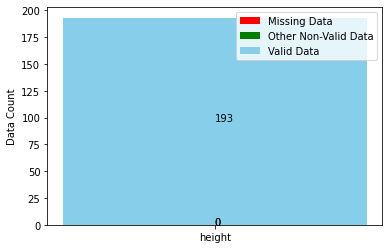

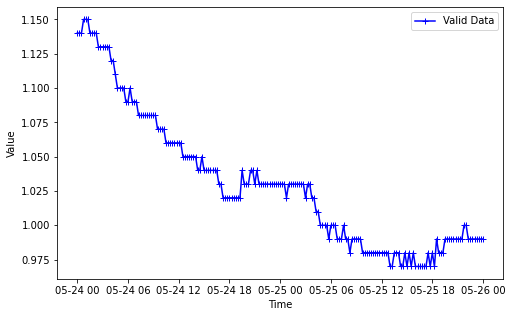

In [15]:
# Plotting column names and missing value.
data_column_name = 'height'
time_column_name = 'datetime'
missing_value = 'M'

# Plot the valid, missing, and non-valid data as a bar chart.
plotting.plot_missing_ratio(gage_df, data_column_name)

# Plot the data as a time series.
plotting.plot_data_timeseries(gage_df, data_column_name, time_column_name, missing_value=missing_value)

## 3) Data cleaning.

In [16]:
dt = 15 # Time step in minutes.
data_column = 'height'
time_column = 'datetime'

### Set Missing to NaN. 'M' => NaN

In [17]:
missing_value = 'M'
gage_df.replace(missing_value, np.nan, inplace=True)

### Add NaN values to missing time steps.

In [18]:
gage_df = time_series.standardize_datetime(gage_df, time_column, data_column, dt)

### Interpolation of NaN values.

In [19]:
gage_df = time_series.interpolate_time_series(gage_df, data_column, method='linear')

## 4) Resampling data.

In [20]:
new_dt = 60 # New time step in minutes. 
data_column = 'height'
time_column = 'datetime'
resample_gage_df = time_series.resample_data(gage_df, time_column, data_column, new_dt)
resample_gage_df.head()

,agency,site_no,tz_cd,provis_accept,height,datetime
0,USGS,4234000,EST,P,1.14,2022-05-24 00:00:00
1,USGS,4234000,EST,P,1.15,2022-05-24 01:00:00
2,USGS,4234000,EST,P,1.14,2022-05-24 02:00:00
3,USGS,4234000,EST,P,1.13,2022-05-24 03:00:00
4,USGS,4234000,EST,P,1.12,2022-05-24 04:00:00


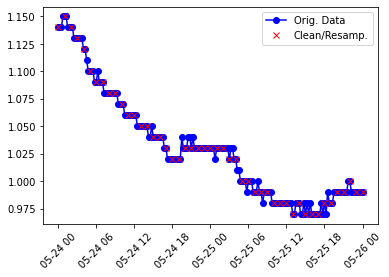

In [21]:
fig, ax = plt.subplots()
ax.plot(gage_df.datetime, gage_df[data_column], 'b-o', label='Orig. Data')
ax.plot(resample_gage_df.datetime, resample_gage_df[data_column], 'rx', label='Clean/Resamp.')
ax.legend()
ax.tick_params(axis='x', rotation=45)
plt.show()

## 5) Save Data Frame.

In [12]:
gage_df.to_csv('<PATH>/.csv', index=False)